Random Forest - Confusion Matrix:
 [[ 21   2]
 [  0 211]]
Random Forest - Classification Report:
               precision    recall  f1-score   support

          -1       1.00      0.91      0.95        23
           1       0.99      1.00      1.00       211

    accuracy                           0.99       234
   macro avg       1.00      0.96      0.97       234
weighted avg       0.99      0.99      0.99       234

Random Forest - AUC: 0.9751699979394189
Support Vector Machine - Confusion Matrix:
 [[ 20   3]
 [  0 211]]
Support Vector Machine - Classification Report:
               precision    recall  f1-score   support

          -1       1.00      0.87      0.93        23
           1       0.99      1.00      0.99       211

    accuracy                           0.99       234
   macro avg       0.99      0.93      0.96       234
weighted avg       0.99      0.99      0.99       234

Support Vector Machine - AUC: 0.9723882134762004
k-Nearest Neighbors - Confusion Matrix:
 [[

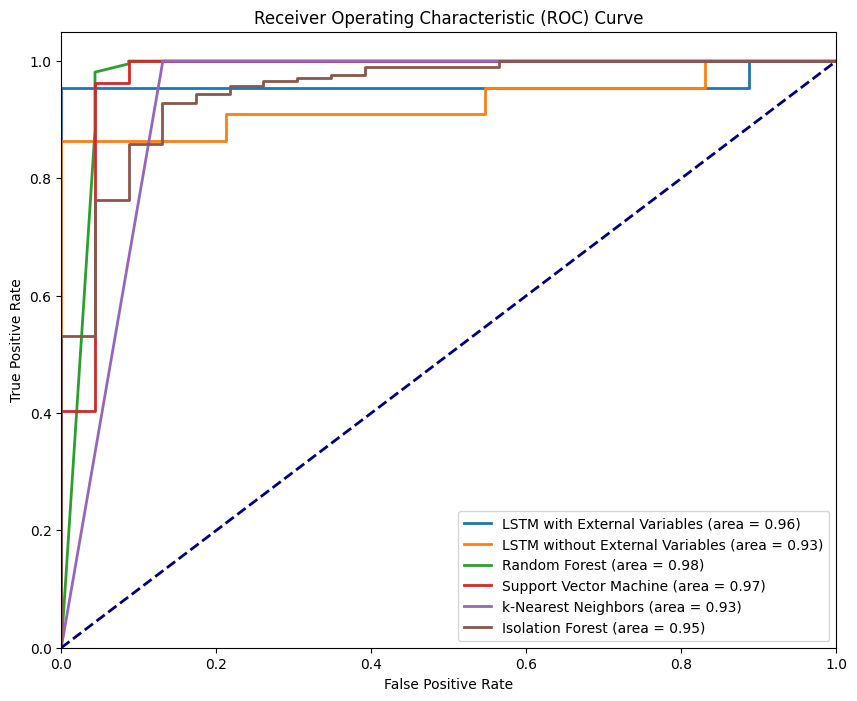

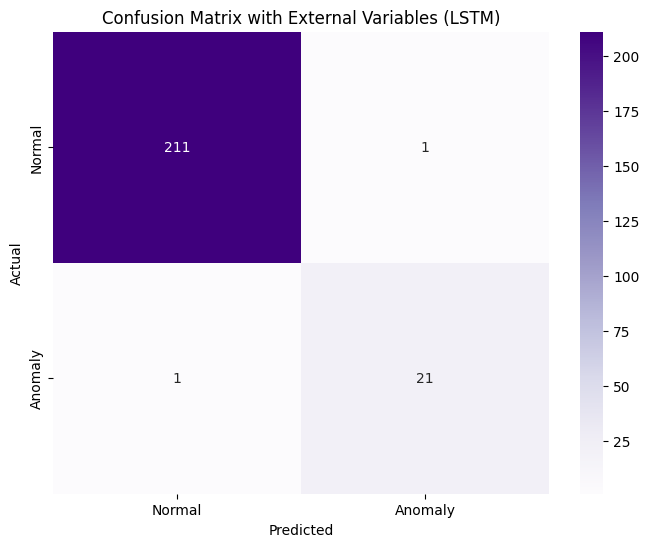

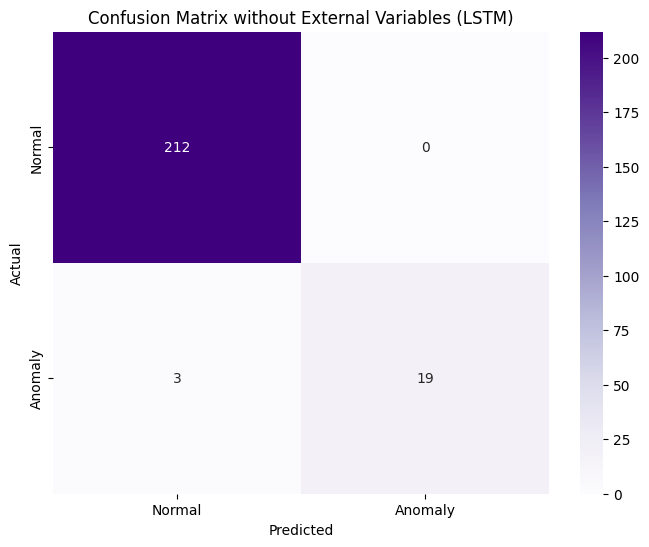

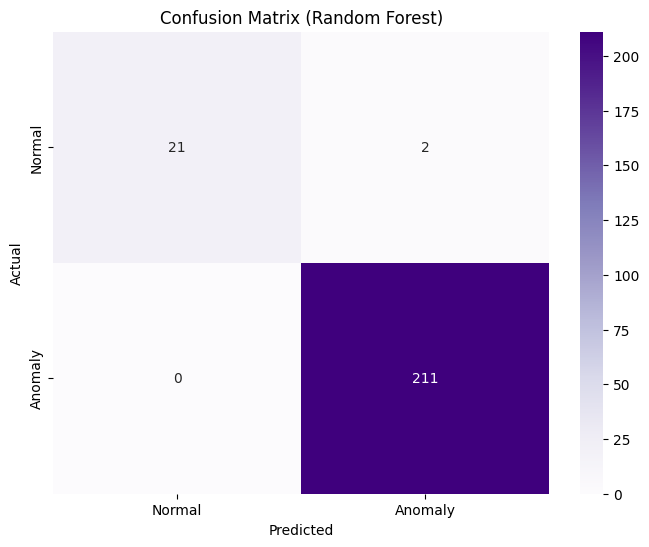

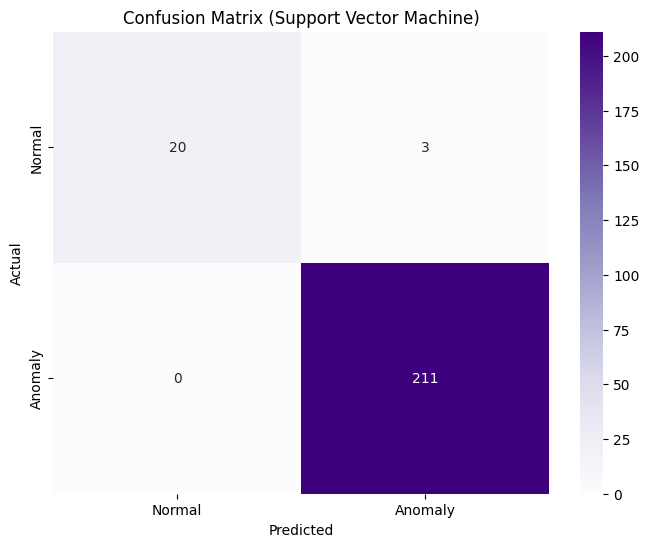

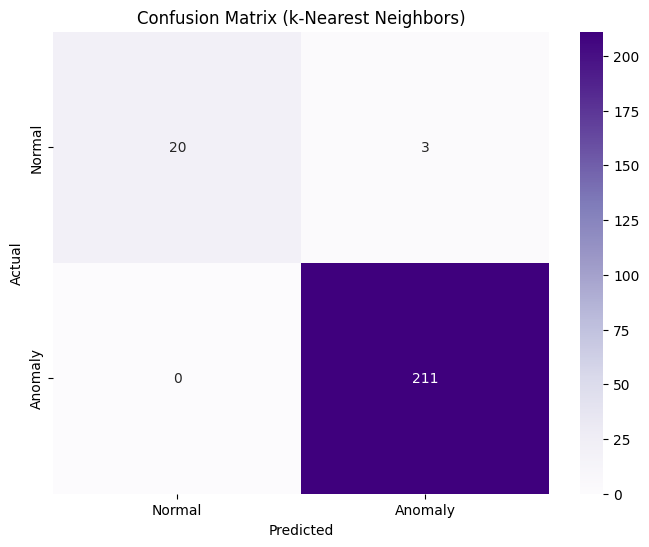

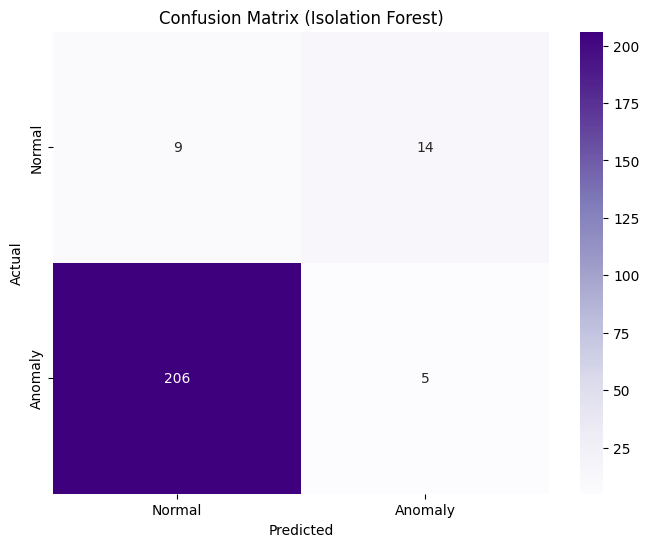

Precision t-statistic: nan, p-value: nan
Recall t-statistic: 17.61190028037906, p-value: 1.0332126430442477e-44
                             Model  Precision    Recall  F1-Score       AUC  \
0     LSTM with External Variables   1.000000  1.000000  1.000000  0.959691   
1  LSTM without External Variables   1.000000  1.000000  1.000000  0.927744   
2                    Random Forest   0.990610  1.000000  0.995283  0.975170   
3           Support Vector Machine   0.985981  1.000000  0.992941  0.972388   
4              k-Nearest Neighbors   0.985981  1.000000  0.992941  0.934474   
5                 Isolation Forest   0.263158  0.023697  0.043478  0.950340   

      Confusion Matrix  
0  [[211, 1], [1, 21]]  
1  [[212, 0], [3, 19]]  
2  [[21, 2], [0, 211]]  
3  [[20, 3], [0, 211]]  
4  [[20, 3], [0, 211]]  
5  [[9, 14], [206, 5]]  


Model,Precision,Recall,F1-Score,AUC,Confusion Matrix
LSTM with External Variables,1.000000,1.000000,1.000000,0.959691,"[[211, 1], [1, 21]]"
LSTM without External Variables,1.000000,1.000000,1.000000,0.927744,"[[212, 0], [3, 19]]"
Random Forest,0.990610,1.000000,0.995283,0.975170,"[[21, 2], [0, 211]]"
Support Vector Machine,0.985981,1.000000,0.992941,0.972388,"[[20, 3], [0, 211]]"
k-Nearest Neighbors,0.985981,1.000000,0.992941,0.934474,"[[20, 3], [0, 211]]"
Isolation Forest,0.263158,0.023697,0.043478,0.950340,"[[9, 14], [206, 5]]"


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, RepeatVector, TimeDistributed, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.model_selection import KFold, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import IsolationForest
from scipy.stats import ttest_rel
import seaborn as sns
import tensorflow as tf

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Load the dataset
file_path = 'baseline_data.csv'
df = pd.read_csv(file_path, parse_dates=['time'], index_col='time')

# Check for missing values and fill if any
df.fillna(method='ffill', inplace=True)

# Normalize the data
scaler = MinMaxScaler()
df[['device_temperature', 'device_humidity', 'climate_temperature', 'climate_humidity']] = scaler.fit_transform(
    df[['device_temperature', 'device_humidity', 'climate_temperature', 'climate_humidity']]
)

# Feature engineering
df['temp_diff'] = df['device_temperature'] - df['climate_temperature']
df['humidity_diff'] = df['device_humidity'] - df['climate_humidity']
df['hour_of_day'] = df.index.hour

# Function to add synthetic anomalies
def add_synthetic_anomalies(df, anomaly_fraction=0.1, seed=42):
    np.random.seed(seed)
    df_with_anomalies = df.copy()
    num_anomalies = int(len(df) * anomaly_fraction)
    anomaly_indices = np.random.choice(df.index, num_anomalies, replace=False)
    df_with_anomalies.loc[anomaly_indices, 'device_temperature'] += np.random.normal(5, 2, size=num_anomalies)
    df_with_anomalies['label'] = 1
    df_with_anomalies.loc[anomaly_indices, 'label'] = -1
    return df_with_anomalies

# Add synthetic anomalies
df_with_anomalies = add_synthetic_anomalies(df)

# Split the data
train_size = int(len(df_with_anomalies) * 0.8)
train, test = np.split(df_with_anomalies, [train_size])
val_size = int(len(train) * 0.2)
train, val = np.split(train, [len(train) - val_size])

# Function to prepare data and train the LSTM model
def train_and_evaluate_lstm(features, train, val, test, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    precision_scores = []
    recall_scores = []
    best_thresholds = []
    histories = []
    
    for train_index, val_index in kf.split(train):
        train_fold, val_fold = train.iloc[train_index], train.iloc[val_index]
        X_train = train_fold[features].values.reshape((train_fold.shape[0], 1, len(features)))
        X_val = val_fold[features].values.reshape((val_fold.shape[0], 1, len(features)))
        X_test = test[features].values.reshape((test.shape[0], 1, len(features)))

        model = Sequential([
            LSTM(32, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
            Dropout(0.2),
            RepeatVector(X_train.shape[1]),
            LSTM(32, activation='relu', return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
            Dropout(0.2),
            TimeDistributed(Dense(X_train.shape[2]))
        ])

        optimizer = Adam(learning_rate=0.001)
        model.compile(optimizer=optimizer, loss='mse')
        history = model.fit(X_train, X_train, epochs=20, batch_size=64, validation_data=(X_val, X_val), verbose=0)
        histories.append(history)

        X_val_pred = model.predict(X_val)
        val_mae_loss = np.mean(np.abs(X_val_pred - X_val), axis=2).flatten()
        
        thresholds = np.linspace(0, max(val_mae_loss), 100)
        precision_scores_fold = []
        recall_scores_fold = []

        for threshold in thresholds:
            y_pred = [1 if score < threshold else -1 for score in val_mae_loss]
            precision = precision_score(val_fold['label'], y_pred, pos_label=-1)
            recall = recall_score(val_fold['label'], y_pred, pos_label=-1)
            precision_scores_fold.append(precision)
            recall_scores_fold.append(recall)

        best_threshold = thresholds[np.argmax([p * r for p, r in zip(precision_scores_fold, recall_scores_fold)])]
        best_thresholds.append(best_threshold)
        precision_scores.append(max(precision_scores_fold))
        recall_scores.append(max(recall_scores_fold))
    
    best_threshold = np.mean(best_thresholds)
    X_test_pred = model.predict(X_test)
    test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=2).flatten()
    y_pred = [1 if score < best_threshold else -1 for score in test_mae_loss]

    cm = confusion_matrix(test['label'], y_pred, labels=[1, -1])
    report = classification_report(test['label'], y_pred, labels=[1, -1])

    fpr, tpr, _ = roc_curve(test['label'], test_mae_loss, pos_label=-1)
    roc_auc = auc(fpr, tpr)

    return best_threshold, cm, report, np.mean(precision_scores), np.mean(recall_scores), test_mae_loss, test['label'].values, histories, fpr, tpr, roc_auc

# Train and evaluate the LSTM model with external variables
features_with_external = ['device_temperature', 'device_humidity', 'climate_temperature', 'climate_humidity', 'hour_of_day']
best_threshold_with_external, cm_with_external, report_with_external, avg_precision_with_external, avg_recall_with_external, test_mae_loss_with_external, test_labels_with_external, histories_with_external, fpr_with_external, tpr_with_external, roc_auc_with_external = train_and_evaluate_lstm(features_with_external, train, val, test)

# Train and evaluate the LSTM model without external variables
features_without_external = ['device_temperature', 'device_humidity']
best_threshold_without_external, cm_without_external, report_without_external, avg_precision_without_external, avg_recall_without_external, test_mae_loss_without_external, test_labels_without_external, histories_without_external, fpr_without_external, tpr_without_external, roc_auc_without_external = train_and_evaluate_lstm(features_without_external, train, val, test)

# Prepare data for traditional ML models
X = df_with_anomalies[['device_temperature', 'device_humidity', 'climate_temperature', 'climate_humidity', 'hour_of_day']]
y = df_with_anomalies['label']
X_train_ml, X_test_ml, y_train_ml, y_test_ml = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Function to train and evaluate traditional ML models
def evaluate_ml_model(model, model_name):
    model.fit(X_train_ml, y_train_ml)
    y_pred = model.predict(X_test_ml)
    cm = confusion_matrix(y_test_ml, y_pred)
    report = classification_report(y_test_ml, y_pred)
    
    # Calculate AUC for the test set
    if hasattr(model, "predict_proba"):
        y_pred_proba = model.predict_proba(X_test_ml)[:, 1]
    elif hasattr(model, "decision_function"):
        y_pred_proba = model.decision_function(X_test_ml)
    else:
        y_pred_proba = y_pred

    fpr, tpr, _ = roc_curve(y_test_ml, y_pred_proba, pos_label=1)
    roc_auc = auc(fpr, tpr)
    
    print(f"{model_name} - Confusion Matrix:\n", cm)
    print(f"{model_name} - Classification Report:\n", report)
    print(f"{model_name} - AUC: {roc_auc}")
    
    return y_pred, fpr, tpr, roc_auc, cm, report

# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_pred, rf_fpr, rf_tpr, rf_auc, rf_cm, rf_report = evaluate_ml_model(rf, "Random Forest")

# Support Vector Machine
svm = SVC(kernel='rbf', probability=True, random_state=42)
svm_pred, svm_fpr, svm_tpr, svm_auc, svm_cm, svm_report = evaluate_ml_model(svm, "Support Vector Machine")

# k-Nearest Neighbors
knn = KNeighborsClassifier(n_neighbors=5)
knn_pred, knn_fpr, knn_tpr, knn_auc, knn_cm, knn_report = evaluate_ml_model(knn, "k-Nearest Neighbors")

# Isolation Forest (for anomaly detection)
iso_forest = IsolationForest(contamination=0.1, random_state=42)
iso_forest.fit(X_train_ml)
iso_forest_pred = iso_forest.predict(X_test_ml)
iso_forest_pred = np.where(iso_forest_pred == 1, -1, 1)  # Convert 1 to -1 for normal and -1 to 1 for anomalies
iso_forest_cm = confusion_matrix(y_test_ml, iso_forest_pred)
iso_forest_report = classification_report(y_test_ml, iso_forest_pred)
iso_forest_fpr, iso_forest_tpr, _ = roc_curve(y_test_ml, iso_forest.decision_function(X_test_ml), pos_label=1)
iso_forest_auc = auc(iso_forest_fpr, iso_forest_tpr)
print("Isolation Forest - Confusion Matrix:\n", iso_forest_cm)
print("Isolation Forest - Classification Report:\n", iso_forest_report)
print(f"Isolation Forest - AUC: {iso_forest_auc}")

# Plot ROC Curves
def plot_combined_roc_curve(roc_data):
    plt.figure(figsize=(10, 8))
    for model_name, (fpr, tpr, roc_auc) in roc_data.items():
        plt.plot(fpr, tpr, lw=2, label=f'{model_name} (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

# Prepare ROC data
roc_data = {
    "LSTM with External Variables": (fpr_with_external, tpr_with_external, roc_auc_with_external),
    "LSTM without External Variables": (fpr_without_external, tpr_without_external, roc_auc_without_external),
    "Random Forest": (rf_fpr, rf_tpr, rf_auc),
    "Support Vector Machine": (svm_fpr, svm_tpr, svm_auc),
    "k-Nearest Neighbors": (knn_fpr, knn_tpr, knn_auc),
    "Isolation Forest": (iso_forest_fpr, iso_forest_tpr, iso_forest_auc)
}

# Plot combined ROC curve
plot_combined_roc_curve(roc_data)

# Plot confusion matrix
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Purples", xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title(title)
    plt.show()

# Plot confusion matrices for LSTM models
plot_confusion_matrix(cm_with_external, "Confusion Matrix with External Variables (LSTM)")
plot_confusion_matrix(cm_without_external, "Confusion Matrix without External Variables (LSTM)")

# Confusion matrices for traditional ML models
plot_confusion_matrix(rf_cm, "Confusion Matrix (Random Forest)")
plot_confusion_matrix(svm_cm, "Confusion Matrix (Support Vector Machine)")
plot_confusion_matrix(knn_cm, "Confusion Matrix (k-Nearest Neighbors)")
plot_confusion_matrix(iso_forest_cm, "Confusion Matrix (Isolation Forest)")

# Statistical significance test
t_stat_precision, p_value_precision = ttest_rel(test_labels_with_external, test_labels_without_external)
t_stat_recall, p_value_recall = ttest_rel(test_mae_loss_with_external, test_mae_loss_without_external)
print(f"Precision t-statistic: {t_stat_precision}, p-value: {p_value_precision}")
print(f"Recall t-statistic: {t_stat_recall}, p-value: {p_value_recall}")

# Calculate F1-Score for traditional models
rf_f1 = 2 * (precision_score(y_test_ml, rf_pred) * recall_score(y_test_ml, rf_pred)) / (precision_score(y_test_ml, rf_pred) + recall_score(y_test_ml, rf_pred))
svm_f1 = 2 * (precision_score(y_test_ml, svm_pred) * recall_score(y_test_ml, svm_pred)) / (precision_score(y_test_ml, svm_pred) + recall_score(y_test_ml, svm_pred))
knn_f1 = 2 * (precision_score(y_test_ml, knn_pred) * recall_score(y_test_ml, knn_pred)) / (precision_score(y_test_ml, knn_pred) + recall_score(y_test_ml, knn_pred))
iso_forest_f1 = 2 * (precision_score(y_test_ml, iso_forest_pred) * recall_score(y_test_ml, iso_forest_pred)) / (precision_score(y_test_ml, iso_forest_pred) + recall_score(y_test_ml, iso_forest_pred))

# Compile evaluation metrics into a dictionary
evaluation_data = {
    "Model": ["LSTM with External Variables", "LSTM without External Variables", "Random Forest", "Support Vector Machine", "k-Nearest Neighbors", "Isolation Forest"],
    "Precision": [avg_precision_with_external, avg_precision_without_external, precision_score(y_test_ml, rf_pred), precision_score(y_test_ml, svm_pred), precision_score(y_test_ml, knn_pred), precision_score(y_test_ml, iso_forest_pred)],
    "Recall": [avg_recall_with_external, avg_recall_without_external, recall_score(y_test_ml, rf_pred), recall_score(y_test_ml, svm_pred), recall_score(y_test_ml, knn_pred), recall_score(y_test_ml, iso_forest_pred)],
    "F1-Score": [2 * (avg_precision_with_external * avg_recall_with_external) / (avg_precision_with_external + avg_recall_with_external),
                 2 * (avg_precision_without_external * avg_recall_without_external) / (avg_precision_without_external + avg_recall_without_external),
                 rf_f1, svm_f1, knn_f1, iso_forest_f1],
    "AUC": [roc_auc_with_external, roc_auc_without_external, rf_auc, svm_auc, knn_auc, iso_forest_auc],
    "Confusion Matrix": [cm_with_external, cm_without_external, rf_cm, svm_cm, knn_cm, iso_forest_cm]
}

# Create DataFrame
evaluation_df = pd.DataFrame(evaluation_data)

# Display the table
pd.set_option('display.max_colwidth', None)
print(evaluation_df)

# Save to a CSV file
evaluation_df.to_csv('model_evaluation_comparison.csv', index=False)

# Display the table in a formatted way
from IPython.display import display, HTML
display(HTML(evaluation_df.to_html(index=False)))


In [14]:
import pandas as pd

# Compile evaluation metrics into a dictionary
evaluation_data = {
    "Model": ["LSTM with External Variables", "LSTM without External Variables", "Random Forest", "Support Vector Machine", "k-Nearest Neighbors", "Isolation Forest"],
    "Precision": [avg_precision_with_external, avg_precision_without_external, precision_score(y_test_ml, rf_pred), precision_score(y_test_ml, svm_pred), precision_score(y_test_ml, knn_pred), precision_score(y_test_ml, iso_forest_pred)],
    "Recall": [avg_recall_with_external, avg_recall_without_external, recall_score(y_test_ml, rf_pred), recall_score(y_test_ml, svm_pred), recall_score(y_test_ml, knn_pred), recall_score(y_test_ml, iso_forest_pred)],
    "F1-Score": [2 * (avg_precision_with_external * avg_recall_with_external) / (avg_precision_with_external + avg_recall_with_external),
                 2 * (avg_precision_without_external * avg_recall_without_external) / (avg_precision_without_external + avg_recall_without_external),
                 2 * (precision_score(y_test_ml, rf_pred) * recall_score(y_test_ml, rf_pred)) / (precision_score(y_test_ml, rf_pred) + recall_score(y_test_ml, rf_pred)),
                 2 * (precision_score(y_test_ml, svm_pred) * recall_score(y_test_ml, svm_pred)) / (precision_score(y_test_ml, svm_pred) + recall_score(y_test_ml, svm_pred)),
                 2 * (precision_score(y_test_ml, knn_pred) * recall_score(y_test_ml, knn_pred)) / (precision_score(y_test_ml, knn_pred) + recall_score(y_test_ml, knn_pred)),
                 2 * (precision_score(y_test_ml, iso_forest_pred) * recall_score(y_test_ml, iso_forest_pred)) / (precision_score(y_test_ml, iso_forest_pred) + recall_score(y_test_ml, iso_forest_pred))],
    "AUC": [roc_auc_with_external, roc_auc_without_external, rf_auc, svm_auc, knn_auc, iso_forest_auc],
    "Confusion Matrix": [cm_with_external, cm_without_external, rf_cm, svm_cm, knn_cm, iso_forest_cm]
}

# Create DataFrame
evaluation_df = pd.DataFrame(evaluation_data)

# Display the table
pd.set_option('display.max_colwidth', None)
print(evaluation_df)

# Save to a CSV file
evaluation_df.to_csv('model_evaluation_comparison.csv', index=False)


                             Model  Precision    Recall  F1-Score       AUC  \
0     LSTM with External Variables   1.000000  1.000000  1.000000  0.958405   
1  LSTM without External Variables   1.000000  1.000000  1.000000  0.949614   
2                    Random Forest   0.990610  1.000000  0.995283  0.975170   
3           Support Vector Machine   0.985981  1.000000  0.992941  0.972388   
4              k-Nearest Neighbors   0.985981  1.000000  0.992941  0.934474   
5                 Isolation Forest   0.263158  0.023697  0.043478  0.950340   

      Confusion Matrix  
0  [[211, 1], [3, 19]]  
1  [[212, 0], [4, 18]]  
2  [[21, 2], [0, 211]]  
3  [[20, 3], [0, 211]]  
4  [[20, 3], [0, 211]]  
5  [[9, 14], [206, 5]]  
